In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from WindPy import w
import scipy.optimize as sco
import datetime
import empyrical
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [52]:
start_date, end_date = '2010-01-01', datetime.datetime.today() - datetime.timedelta(2)

In [53]:
codes = 'CBA02701.CS,CBA02511.CS,CBA02531.CS,CBA02551.CS'

In [62]:
data = w.wsd(codes, 'close', start_date, end_date)

In [63]:
df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=[u'信用债', u'国开：1年以下', u'国开：3-5年', u'国开：7-10年'])

In [66]:
returns = df.pct_change().dropna()

In [67]:
returns.head()

,信用债,国开：1年以下,国开：3-5年,国开：7-10年
2010-01-05,0.000197,0.000053,-0.000057,0.001108
2010-01-06,0.000298,0.000096,0.000289,-0.000284
2010-01-07,-0.000041,0.000029,0.000003,0.000286
2010-01-08,-0.000190,-0.000100,-0.000292,-0.000593
2010-01-11,-0.000040,0.000211,0.000511,0.000208


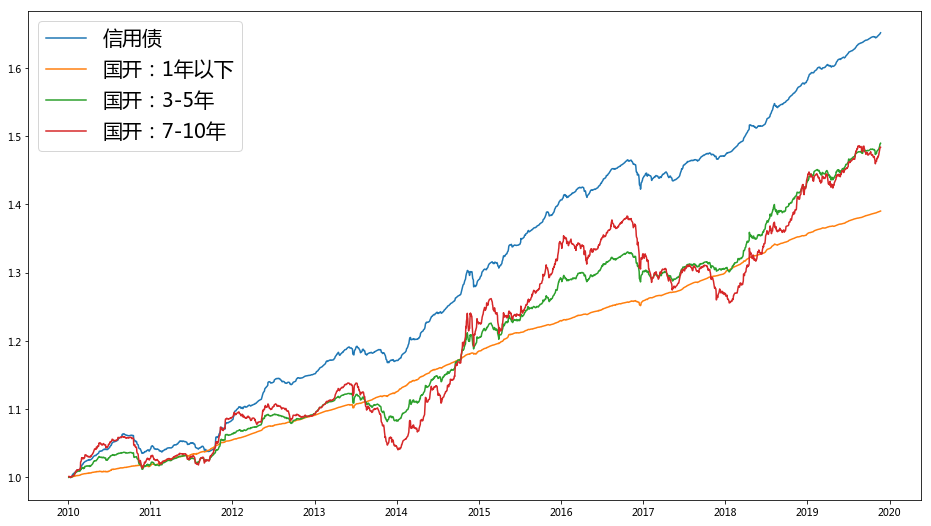

In [70]:
(1 + returns).cumprod().plot(figsize=(16, 9))

plt.legend(fontsize=20)

In [71]:
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 10000
results = np.zeros((3,num_portfolios))

In [72]:
for i in xrange(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.random.random(4)
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]

In [73]:
results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe'])

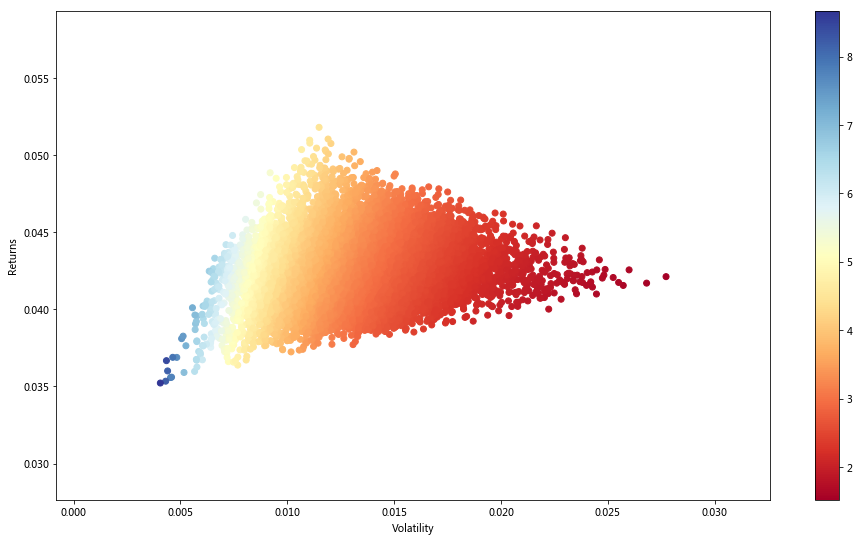

In [74]:
plt.figure(figsize=(16, 9))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

In [75]:
def calcPortfolioPerf(weights, meanReturns, covMatrix):
    '''
    Calculates the expected mean of returns and volatility for a portolio of
    assets, each carrying the weight specified by weights

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio

    OUTPUT
    tuple containing the portfolio return and volatility
    '''    
    #Calculate return and variance

    portReturn = np.sum( meanReturns*weights ) * 252
    portStdDev = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)

    return portReturn, portStdDev

In [76]:
def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    '''
    Returns the negated Sharpe Ratio for the speicified portfolio of assets

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    p_ret, p_var = calcPortfolioPerf(weights, meanReturns, covMatrix)

    return -(p_ret - riskFreeRate) / p_var

In [77]:
def getPortfolioVol(weights, meanReturns, covMatrix):
    '''
    Returns the volatility of the specified portfolio of assets

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio

    OUTPUT
    The portfolio's volatility
    '''
    return calcPortfolioPerf(weights, meanReturns, covMatrix)[1]

In [78]:
def findMaxSharpeRatioPortfolio(meanReturns, covMatrix, riskFreeRate):
    '''
    Finds the portfolio of assets providing the maximum Sharpe Ratio

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(negSharpeRatio, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opts

In [79]:
def findMinVariancePortfolio(meanReturns, covMatrix):
    '''
    Finds the portfolio of assets providing the lowest volatility

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(getPortfolioVol, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opts

In [80]:
maxSharpe = findMaxSharpeRatioPortfolio(returns.mean(), returns.cov(), 0.0)

In [81]:
maxSharpe

     fun: -9.3093735142941
     jac: array([ 1.16218817,  0.        ,  6.64041507, 14.39205158])
 message: 'Optimization terminated successfully.'
    nfev: 18
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([5.12179188e-12, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [82]:
rp, sdp = calcPortfolioPerf(maxSharpe['x'], returns.mean(), returns.cov())

In [83]:
rp, sdp

(0.03456961127105869, 0.003713419728833385)

In [84]:
minVar = findMinVariancePortfolio(returns.mean(), returns.cov())

In [85]:
minVar

     fun: 0.003713419728802022
     jac: array([0.00612353, 0.00371342, 0.00715241, 0.01023378])
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.00000000e+00, 1.00000000e+00, 6.07153217e-18, 0.00000000e+00])

In [86]:
rp_min, sdp_min = calcPortfolioPerf(minVar['x'], returns.mean(), returns.cov())

In [87]:
def findEfficientReturn(meanReturns, covMatrix, targetReturn):
    '''
    Finds the portfolio of assets providing the target return with lowest
    volatility

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    targetReturn: APR of target expected return

    OUTPUT
    Dictionary of results from optimization
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)

    def getPortfolioReturn(weights):
        return calcPortfolioPerf(weights, meanReturns, covMatrix)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: getPortfolioReturn(x) - targetReturn},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(numAssets))

    return sco.minimize(getPortfolioVol, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

In [88]:
def findEfficientFrontier(meanReturns, covMatrix, rangeOfReturns):
    '''
    Finds the set of portfolios comprising the efficient frontier

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    targetReturn: APR of target expected return

    OUTPUT
    Dictionary of results from optimization
    '''
    efficientPortfolios = []
    for ret in rangeOfReturns:
        efficientPortfolios.append(findEfficientReturn(meanReturns, covMatrix, ret))

    return efficientPortfolios

In [96]:
targetReturns = np.linspace(rp_min, 0.052, 50)

In [97]:
efficientPortfolios = findEfficientFrontier(returns.mean(), returns.cov(), targetReturns)

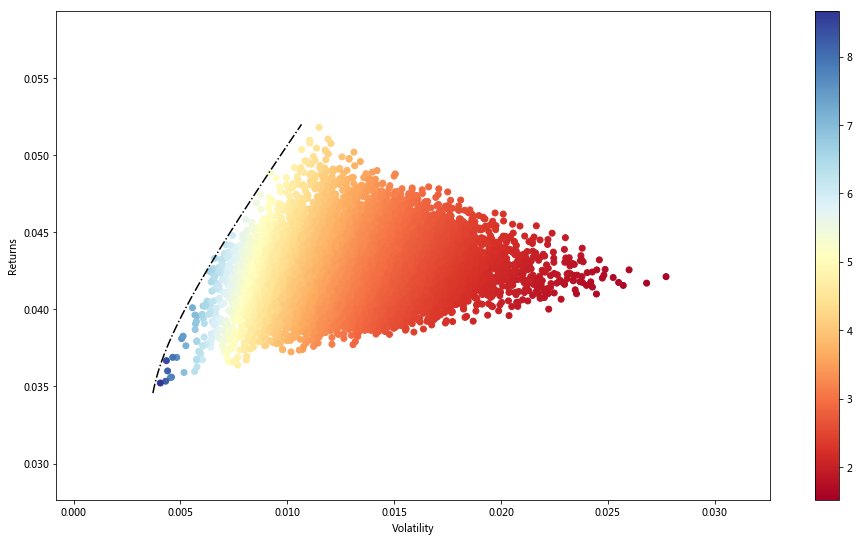

In [98]:
plt.figure(figsize=(16, 9))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.plot([p['fun'] for p in efficientPortfolios], targetReturns, linestyle='-.', color='black', label='efficient frontier')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

In [99]:
for i, e in enumerate(efficientPortfolios):
    print(e.x[0], targetReturns[i])

(5.551115123125783e-17, 0.03456961127078882)
(0.019630452509135164, 0.03492533348975232)
(0.0392609048739425, 0.03528105570871581)
(0.058891357069687934, 0.0356367779276793)
(0.07852180946397828, 0.0359925001466428)
(0.09815226189588032, 0.03634822236560629)
(0.11778271405577473, 0.036703944584569784)
(0.13741316724875965, 0.03705966680353327)
(0.15704361847768722, 0.03741538902249677)
(0.1766740706935051, 0.037771111241460265)
(0.1963045245061381, 0.038126833460423754)
(0.21593497638922404, 0.03848255567938725)
(0.23556542917723347, 0.038838277898350745)
(0.2551958817667394, 0.039194000117314234)
(0.2748263336610318, 0.03954972233627773)
(0.29445678644335443, 0.039905444555241226)
(0.3140872385075803, 0.040261166774204715)
(0.3337176909307747, 0.04061688899316821)
(0.3533481428335468, 0.0409726112121317)
(0.3729785966494327, 0.041328333431095196)
(0.3926090490643464, 0.04168405565005869)
(0.41223950063501263, 0.04203977786902218)
(0.431869953370879, 0.04239550008798568)
(0.45150040544

In [100]:
for i, e in enumerate(efficientPortfolios):
    print(e.x[1:], targetReturns[i])

(array([9.99877801e-01, 1.22198888e-04, 0.00000000e+00]), 0.03456961127078882)
(array([9.80369547e-01, 1.04083409e-17, 0.00000000e+00]), 0.03492533348975232)
(array([9.60739095e-01, 3.64291930e-17, 2.60208521e-18]), 0.03528105570871581)
(array([9.41108643e-01, 0.00000000e+00, 2.60208521e-17]), 0.0356367779276793)
(array([9.21478191e-01, 4.51028104e-17, 0.00000000e+00]), 0.0359925001466428)
(array([9.01847738e-01, 1.38777878e-17, 0.00000000e+00]), 0.03634822236560629)
(array([8.82217286e-01, 0.00000000e+00, 1.38777878e-17]), 0.036703944584569784)
(array([8.62586833e-01, 0.00000000e+00, 1.73472348e-18]), 0.03705966680353327)
(array([8.42956382e-01, 4.16333634e-17, 0.00000000e+00]), 0.03741538902249677)
(array([8.23325929e-01, 1.38777878e-16, 0.00000000e+00]), 0.037771111241460265)
(array([8.03695475e-01, 0.00000000e+00, 5.35595873e-17]), 0.038126833460423754)
(array([7.84065024e-01, 5.55111512e-17, 5.72458747e-17]), 0.03848255567938725)
(array([7.64434571e-01, 0.00000000e+00, 5.20417043e

# 业绩基准年化收益率

In [113]:
base_data = w.wsd('H11001.CSI', 'close', start_date, end_date)

In [114]:
base = pd.DataFrame(np.array(base_data.Data).T, index=base_data.Times, columns=base_data.Codes)

In [124]:
base.pct_change().mean() * 252

H11001.CSI    0.046228
dtype: float64

In [125]:
findEfficientFrontier(returns.mean(), returns.cov(), [base.pct_change().mean() * 252])

[     fun: 0.007895147800094681
      jac: array([0.01089925, 0.00247588, 0.01049385, 0.01852955])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 9
     njev: 9
   status: 0
  success: True
        x: array([6.43360946e-01, 3.56639054e-01, 0.00000000e+00, 8.23993651e-17])]